In [40]:
import numpy as np
import pandas as pd
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Data

In [41]:
# variable names key
key = pd.read_csv('data/VariableLookup.csv')
print(key.shape)
key.head()

(83, 3)


,Field,LongName,Description
0,CensusTract,Census tract,Census tract number
1,State,State,State name
2,County,County,County name
3,Urban,Urban tract,Flag for urban tract
4,POP2010,"Population, tract total",Population count from 2010 census


In [42]:
# full dataset
df = pd.read_csv('data/USDA_ERS_data.csv')

In [43]:
# rename hispanic columns for compatibility
df = df.rename(columns = {'lahisp1':'lahispanic1', 
                          'lahisp1share':'lahispanic1share', 
                          'lahisp10':'lahispanic10', 
                          'lahisp10share':'lahispanic10share'})
df.columns

Index(['CensusTract', 'State', 'County', 'Urban', 'Pop2010', 'OHU2010',
       'GroupQuartersFlag', 'NUMGQTRS', 'PCTGQTRS', 'LILATracts_1And10',
       'HUNVFlag', 'LowIncomeTracts', 'PovertyRate', 'MedianFamilyIncome',
       'LA1and10', 'LATracts1', 'LATracts10', 'LAPOP1_10', 'LALOWI1_10',
       'lapop1', 'lapop1share', 'lalowi1', 'lalowi1share', 'lakids1',
       'lakids1share', 'laseniors1', 'laseniors1share', 'lawhite1',
       'lawhite1share', 'lablack1', 'lablack1share', 'laasian1',
       'laasian1share', 'lanhopi1', 'lanhopi1share', 'laaian1', 'laaian1share',
       'laomultir1', 'laomultir1share', 'lahispanic1', 'lahispanic1share',
       'lahunv1', 'lahunv1share', 'lasnap1', 'lasnap1share', 'lapop10',
       'lapop10share', 'lalowi10', 'lalowi10share', 'lakids10',
       'lakids10share', 'laseniors10', 'laseniors10share', 'lawhite10',
       'lawhite10share', 'lablack10', 'lablack10share', 'laasian10',
       'laasian10share', 'lanhopi10', 'lanhopi10share', 'laaian10',
    

In [44]:
# adding column for adults (age 18-64)
df['laadults1'] = df['lapop1'] - df['lakids1'] - df['laseniors1']
df['laadults10'] = df['lapop10'] - df['lakids10'] - df['laseniors10']
df['TractAdults'] = df['Pop2010'] - df['TractKids'] - df['TractSeniors']
print(df.shape)
df.head()

(72531, 86)


,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,laadults1,laadults10,TractAdults
0,1001020100,Alabama,Autauga County,1,1912,693,0,0.0,0.00,0,...,14.0,0.0,14.0,45.0,44.0,6.0,102.0,1173.0,NaN,1184.0
1,1001020200,Alabama,Autauga County,1,2170,743,0,181.0,8.34,1,...,5.0,0.0,5.0,55.0,75.0,89.0,156.0,728.0,NaN,1350.0
2,1001020300,Alabama,Autauga County,1,3373,1256,0,0.0,0.00,0,...,17.0,5.0,11.0,117.0,87.0,99.0,172.0,935.0,NaN,2040.0
3,1001020400,Alabama,Autauga County,1,4386,1722,0,0.0,0.00,0,...,18.0,4.0,11.0,74.0,85.0,21.0,98.0,780.0,NaN,2467.0
4,1001020500,Alabama,Autauga County,1,10766,4082,0,181.0,1.68,0,...,296.0,9.0,48.0,310.0,355.0,230.0,339.0,1566.0,NaN,6478.0


# State

In [45]:
# group by states
state_df = df.groupby(by='State').sum().reset_index()
state_df['prop_insecure'] = (state_df['LALOWI1_10']/state_df['Pop2010']) * 100
print(state_df.shape)
state_df.head()

(51, 86)


,State,CensusTract,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,HUNVFlag,...,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,laadults1,laadults10,TractAdults,prop_insecure
0,Alabama,1267818290482,644,4779736,1883791,4,115816.0,2973.89,267,347,...,3057.0,28218.0,168161.0,185602.0,115360.0,269603.0,1829544.0,75239.0,2989485.0,8.760756
1,Alaska,351430086585,84,710231,258058,1,26343.0,739.26,33,51,...,7409.0,97786.0,62823.0,39242.0,22474.0,25855.0,252767.0,42001.0,463961.0,7.868708
2,Arizona,6102878346451,1292,6392017,2380990,16,137469.0,3065.05,257,284,...,12648.0,296529.0,980016.0,1895149.0,160011.0,298356.0,1342250.0,145030.0,3881172.0,8.680077
3,Arkansas,3484080853747,335,2915918,1147084,1,78931.0,1880.62,171,232,...,5863.0,22248.0,156581.0,186050.0,73619.0,146798.0,1083580.0,103658.0,1784462.0,10.015748
4,California,48584591545832,7353,37253956,12577498,67,819805.0,18522.21,536,755,...,144386.0,362801.0,8132756.0,14013719.0,939034.0,1184714.0,4299125.0,128381.0,23712402.0,3.234459


In [46]:
# ranking states by total insecure
state_df_total = state_df.sort_values(by='LALOWI1_10', ascending=False).reset_index()[['State', 'LALOWI1_10', 'Pop2010', 'prop_insecure']]
state_df_total

,State,LALOWI1_10,Pop2010,prop_insecure
0,Texas,2099610.0,25145561,8.349824
1,Florida,1427401.0,18801310,7.592029
2,California,1204964.0,37253956,3.234459
3,Georgia,971069.0,9687653,10.023780
4,Ohio,792535.0,11536504,6.869802
5,North Carolina,715209.0,9535483,7.500501
6,Michigan,630369.0,9883640,6.377903
7,Illinois,619810.0,12830632,4.830705
8,Pennsylvania,582750.0,12702379,4.587723
9,Tennessee,563080.0,6346105,8.872844


In [47]:
# ranking states by proportion insecure
state_df_prop = state_df_total.sort_values(by='prop_insecure', ascending=False).reset_index()

# create better looking column for percentages, seen in interactive map
prop_insecure = np.round(state_df_prop['prop_insecure'].values, 2)
names = state_df_prop['State']
percent_insecure = []
for i in range(51):
    percent_insecure.append(names[i] + ': ' + str(prop_insecure[i]) + '%')

state_df_prop[''] = percent_insecure
state_df_prop.rename(columns={'prop_insecure':'Percent Food-Insecure'}, inplace = True)
state_df_prop

,index,State,LALOWI1_10,Pop2010,Percent Food-Insecure,
0,26,New Mexico,268517.0,2059179,13.040003,New Mexico: 13.04%
1,19,Mississippi,337495.0,2967297,11.373819,Mississippi: 11.37%
2,12,Louisiana,483383.0,4533372,10.662769,Louisiana: 10.66%
3,3,Georgia,971069.0,9687653,10.023780,Georgia: 10.02%
4,23,Arkansas,292051.0,2915918,10.015748,Arkansas: 10.02%
5,14,South Carolina,450978.0,4625364,9.750108,South Carolina: 9.75%
6,9,Tennessee,563080.0,6346105,8.872844,Tennessee: 8.87%
7,20,Oklahoma,332607.0,3751351,8.866326,Oklahoma: 8.87%
8,16,Alabama,418741.0,4779736,8.760756,Alabama: 8.76%
9,11,Arizona,554832.0,6392017,8.680077,Arizona: 8.68%


In [48]:
# creates dataframe from above to be used for table below
state_final_df = pd.DataFrame({'State': state_df_prop['State'].values,
                               'Total Insecure':state_df_prop['LALOWI1_10'].values,
                               'Percent Insecure':np.round(state_df_prop['Percent Food-Insecure'].values, 2)})
# formatting large numbers
state_final_df['Total Insecure'] = state_final_df.apply(lambda x: "{:,.0f}".format(x['Total Insecure']), axis=1)

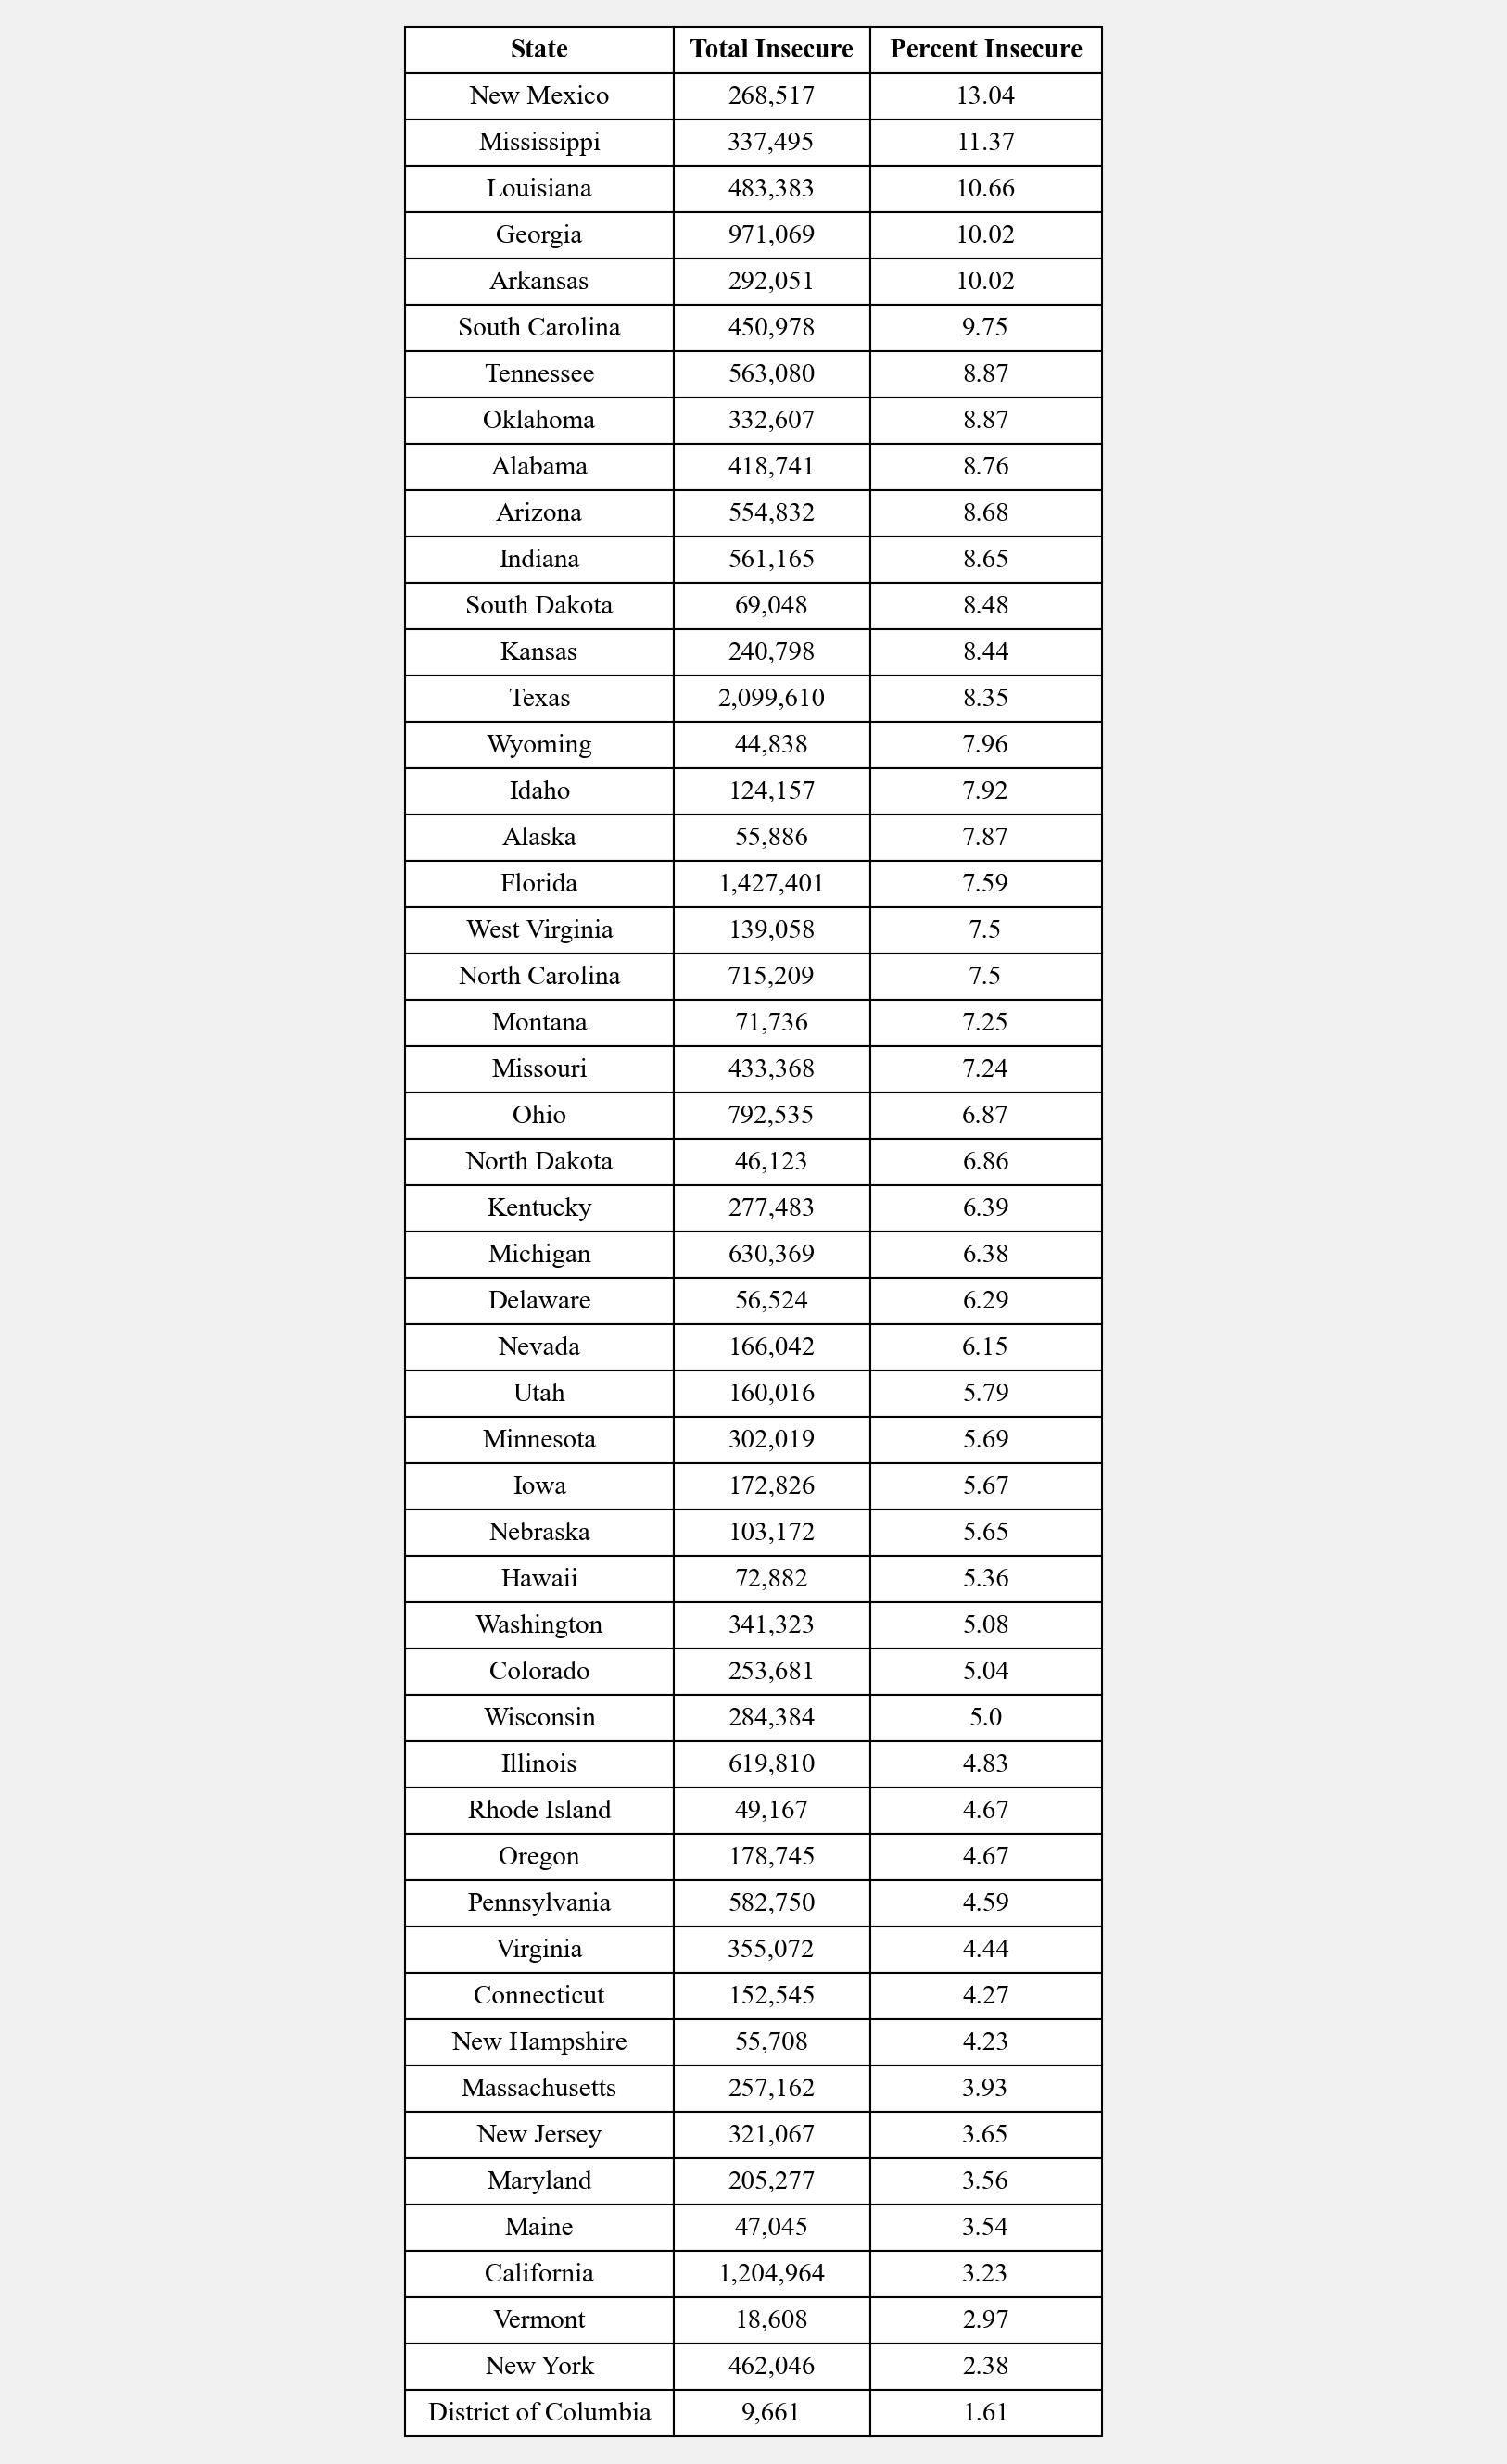

In [49]:
# creates table from above dataframe
table = plt.table(cellText = state_final_df.values,
              colLabels = state_final_df.columns,
              loc='center', 
              cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(7)
table.auto_set_column_width((0, 1, 2))
# bold column headings
for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold', size=7))

plt.axis('off')

# saves figure as png
plt.savefig('figures/geography/state-table.png', bbox_inches = 'tight', transparent = True)
plt.show();

In [59]:
# import u.s state map info
states = gpd.read_file('geopandas_map/cb_2020_us_state_20m.shp')
states = states.rename(columns={'NAME':'State'})
states = states.merge(state_df_prop)

# drop hawaii, alaska
mainland = states.drop([20, 25])

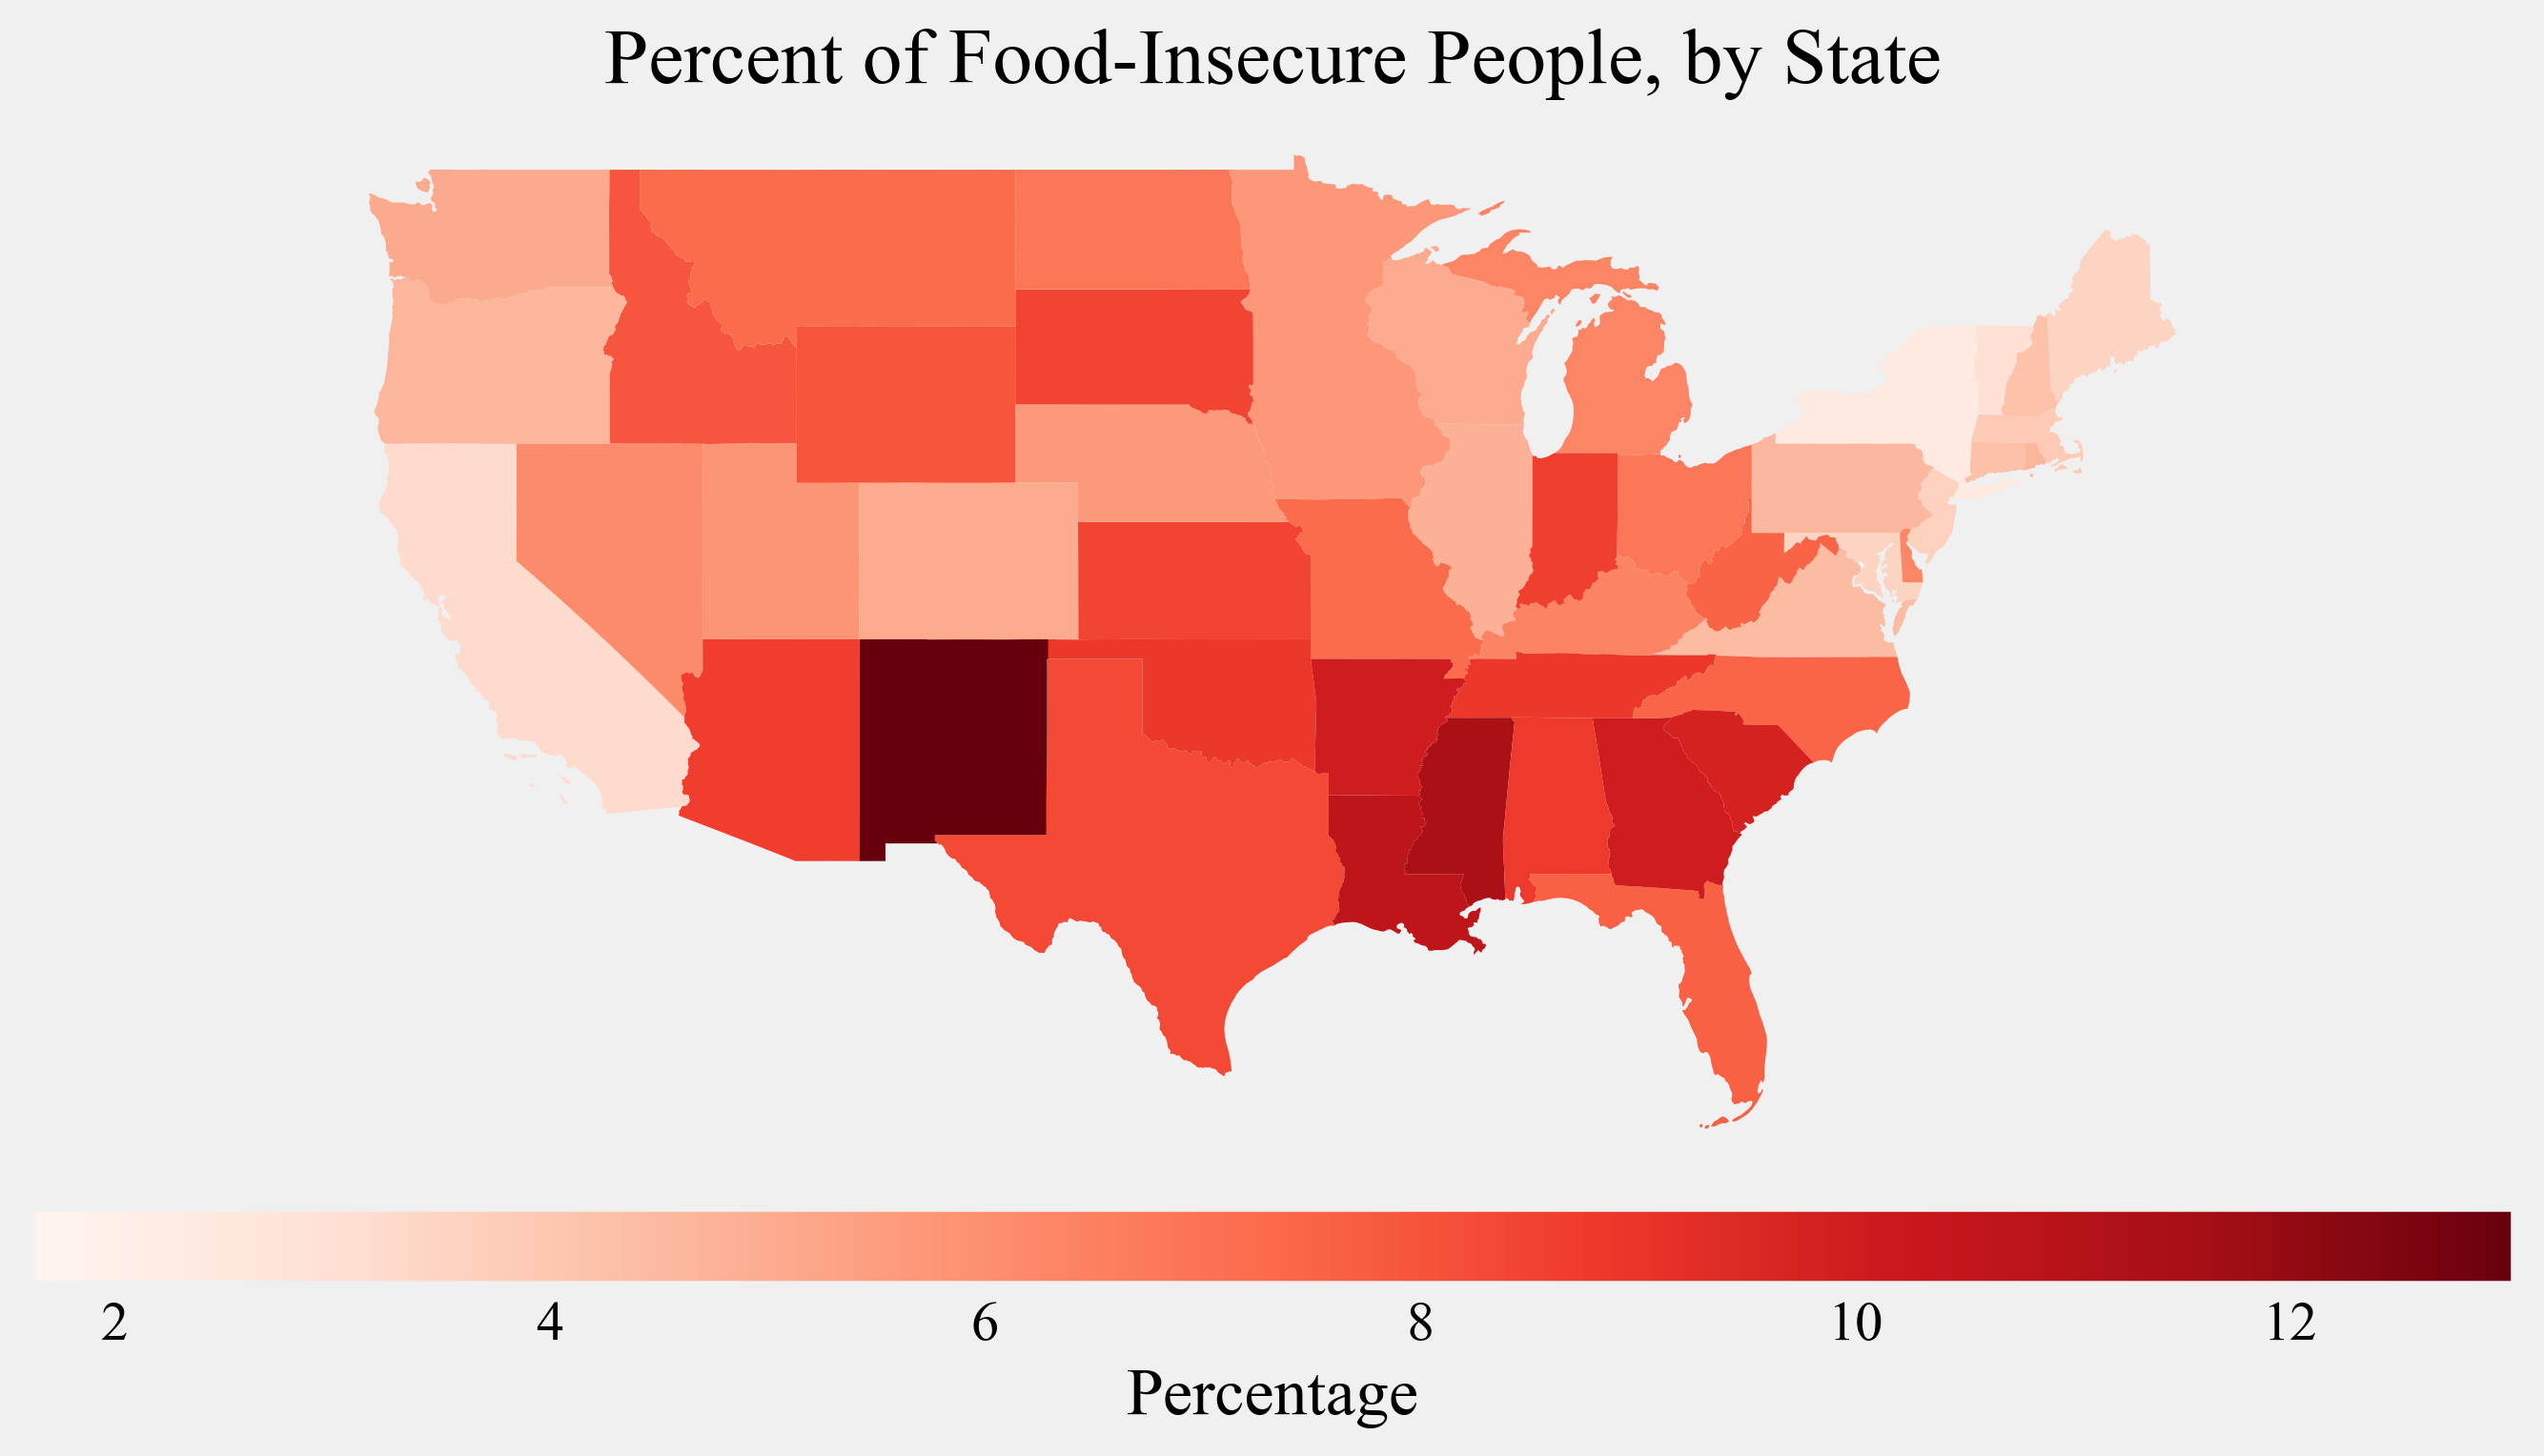

In [60]:
# creates choropleth of percentage of food insecure people by state
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="7.5%", pad=0.1)

# map
us_map = mainland.plot(column='Percent Food-Insecure', ax=ax, cax=cax, legend=True, cmap='Reds',
                       legend_kwds={'label': "Percentage",'orientation': "horizontal"})
fig.set_size_inches(10, 10)
us_map.axis('off')
ax.set_title('Percent of Food-Insecure People, by State', size = 20)

# saves figure as png
plt.savefig('figures/geography/state-percentage-map.png', bbox_inches = 'tight', transparent = True)
plt.show()

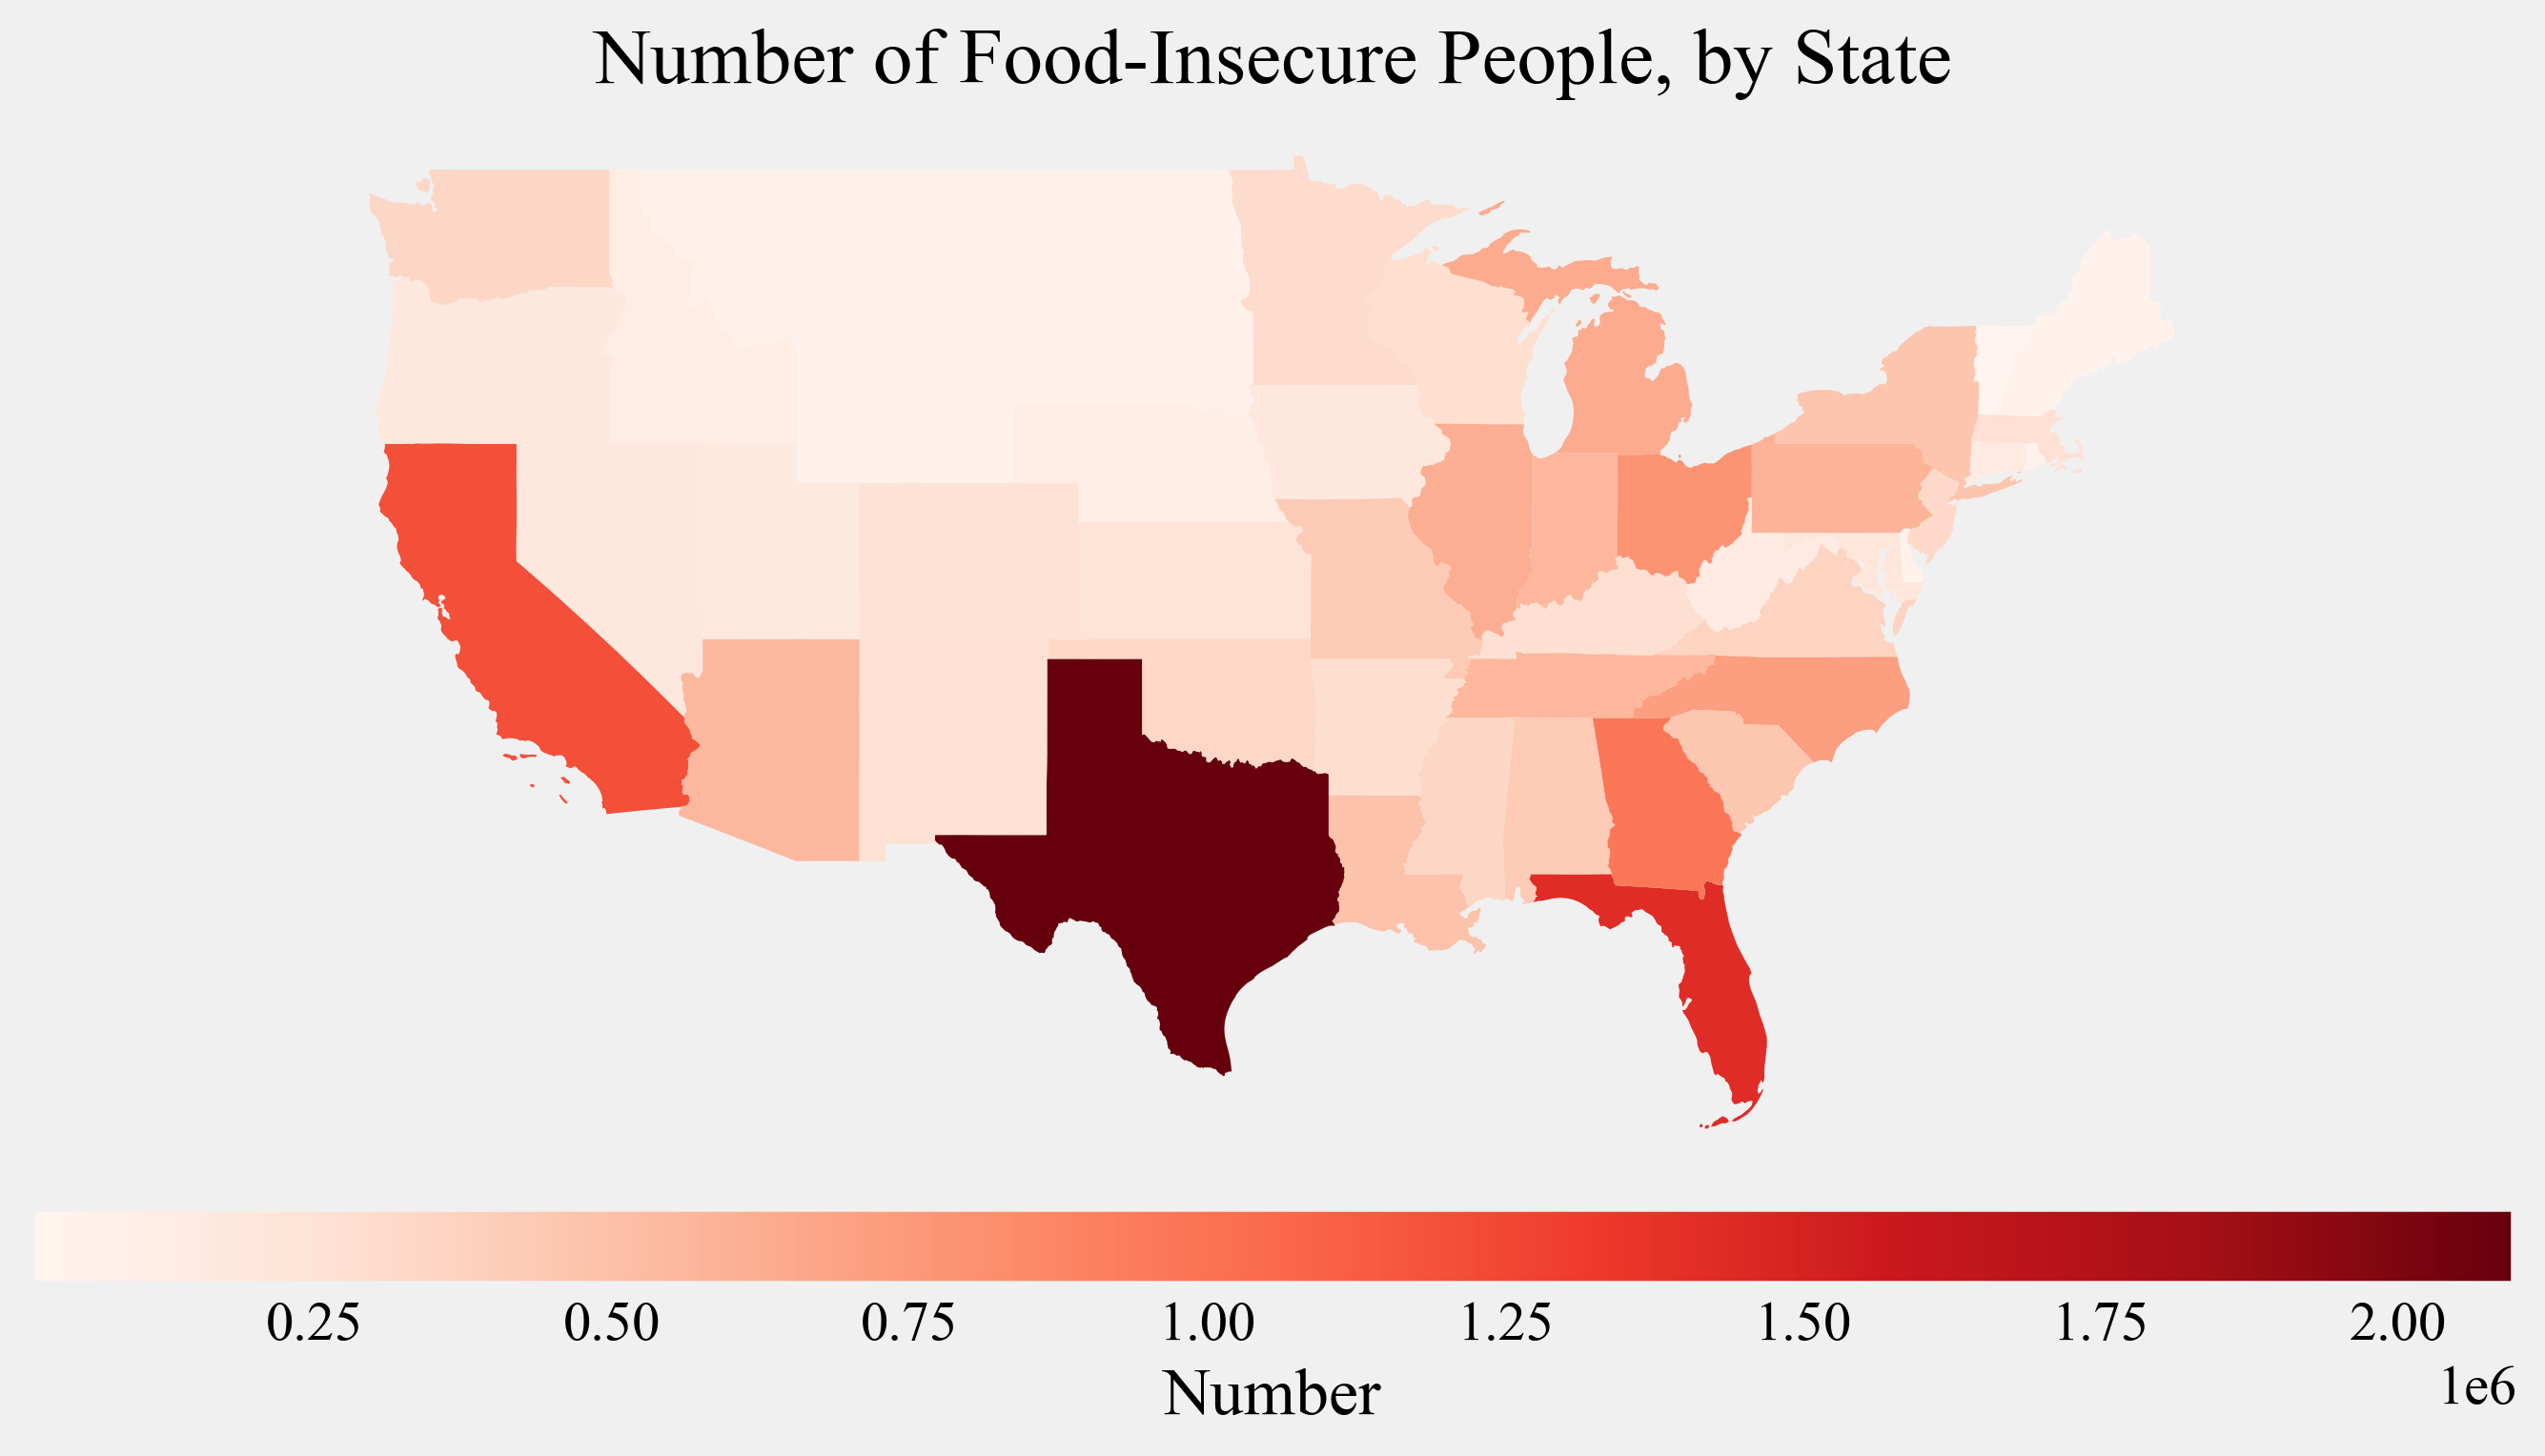

In [61]:
# creates choropleth of percentage of total insecure people by state
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="7.5%", pad=0.1)

# map
us_map = mainland.plot(column='LALOWI1_10', ax=ax, cax=cax, legend=True, cmap='Reds',
                       legend_kwds={'label': "Number",'orientation': "horizontal"})
fig.set_size_inches(10, 10)
us_map.axis('off')
ax.set_title('Number of Food-Insecure People, by State', size = 20)

# saves figure as png
plt.savefig('figures/geography/state-total-map.png', bbox_inches = 'tight', transparent = True)
plt.show()

In [62]:
# interactive map
states.explore(column = "Percent Food-Insecure", # make choropleth based on "Percent Food-Insecure" column
               tooltip = "", # show "" value in state_df_prop (on hover)
               popup = True, # show all values in popup (on click)
               tiles = "CartoDB positron", # use "CartoDB positron" tiles
               cmap = "Reds", # use "Reds" matplotlib colormap
               style_kwds = dict(color="black") # use black outline
              )

# County

In [54]:
# group by counties
county_df = df.groupby(['State', 'County']).sum().reset_index()
county_df['prop_insecure'] = (county_df['LALOWI1_10']/county_df['Pop2010']) * 100
print(county_df.shape)
county_df.head()

(3142, 87)


,State,County,CensusTract,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,laadults1,laadults10,TractAdults,prop_insecure
0,Alabama,Autauga County,12012247403,7,54571,20221,0,455.0,12.86,5,...,32.0,232.0,1335.0,1310.0,1191.0,2692.0,23058.0,3213.0,33412.0,13.021568
1,Alabama,Baldwin County,31093340873,14,182265,73180,0,2307.0,41.05,4,...,89.0,1216.0,6354.0,7992.0,2705.0,5926.0,79981.0,1402.0,109799.0,7.937893
2,Alabama,Barbour County,9053554500,2,27457,9820,0,3193.0,79.74,4,...,29.0,114.0,1152.0,1387.0,849.0,2516.0,12769.0,3223.0,17533.0,10.430856
3,Alabama,Bibb County,4028040010,0,22915,7953,0,2224.0,26.25,0,...,13.0,64.0,388.0,406.0,410.0,849.0,11100.0,203.0,14808.0,0.445123
4,Alabama,Blount County,9081453506,1,57322,21578,0,489.0,7.24,0,...,38.0,307.0,3031.0,4626.0,856.0,1966.0,31159.0,0.0,34777.0,2.512124


In [55]:
# ranking counties by total insecure
county_df_total = county_df.sort_values(by='LALOWI1_10', ascending=False).reset_index()[['State', 'County', 'LALOWI1_10', 'Pop2010', 'prop_insecure']]
county_df_total.head()

,State,County,LALOWI1_10,Pop2010,prop_insecure
0,Texas,Harris County,236346.0,4092459,5.775159
1,Arizona,Maricopa County,210296.0,3817117,5.509289
2,California,San Bernardino County,173576.0,2035210,8.528653
3,Texas,Dallas County,171378.0,2368139,7.236822
4,Texas,Bexar County,166126.0,1714773,9.687930


In [56]:
# ranking counties by proportion insecure
county_df_prop = county_df_total.sort_values(by='prop_insecure', ascending=False).reset_index()
county_df_prop.head()

,index,State,County,LALOWI1_10,Pop2010,prop_insecure
0,780,Mississippi,Quitman County,5147.0,8223,62.592728
1,1136,New Mexico,Mora County,2927.0,4881,59.967220
2,1422,Texas,Hudspeth County,2023.0,3476,58.199079
3,1414,Colorado,Costilla County,2043.0,3524,57.973893
4,2090,Texas,Cottle County,856.0,1505,56.877076
